In [83]:
#from IPython.display import Image,clear_output
#%pip install torch torchvision matplotlib albumentations opencv-python segmentation-models-pytorch
#%pip install roboflow pandas
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#clear_output()

In [84]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key="4QwtaiJqX1nqiPdAyXcV")
dataset = rf.workspace("dron-hkv6n").project("clasificacion-de-suelo-2").version(7).download("png-mask-semantic", location="content/my-datasets")


loading Roboflow workspace...
loading Roboflow project...


In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import pandas as pd
import torch
from segmentation_models_pytorch.losses import FocalLoss
from sklearn.metrics import confusion_matrix, classification_report

In [86]:
dataset_path = "content/my-datasets"

# Rutas de las carpetas
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")

# Obtener listas de archivos
def get_image_mask_paths(folder):
    # Filtrar solo imágenes originales (sin _mask)
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])

    # Generar nombres de las máscaras correctamente
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]

    return image_files, mask_files

train_images, train_masks = get_image_mask_paths(train_path)
test_images, test_masks = get_image_mask_paths(test_path)
valid_images, valid_masks = get_image_mask_paths(valid_path)

print(f"Entrenamiento: {len(train_images)} imágenes")
print(f"Validación: {len(valid_images)} imágenes")
print(f"Prueba: {len(test_images)} imágenes")

Entrenamiento: 150 imágenes
Validación: 22 imágenes
Prueba: 10 imágenes


In [87]:
# Leer el archivo CSV
classes_csv = "content/my-datasets/train/_classes.csv"
classes_df = pd.read_csv(classes_csv)

# Obtener el número de clases
num_classes = len(classes_df)
print(f"Número de clases en segmentación: {num_classes}")
print(classes_df)

Número de clases en segmentación: 5
   Pixel Value              Class
0            0         background
1            1               agua
2            2     suelo expuesto
3            3    vegetacion seca
4            4   vegetacion verde


In [88]:
class SoilDataset(Dataset):
    def __init__(self, folder, image_files, mask_files, transform=None):
        self.folder = folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        mask_path = os.path.join(self.folder, self.mask_files[idx])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Máscara no encontrada: {mask_path}")

        # Cargar imagen y máscara
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Mantener valores originales

        if mask is None:
            raise ValueError(f"Error al cargar la máscara: {mask_path}")

        # Convertir máscara a `int64` antes de las transformaciones
        mask = mask.astype(np.int64)

        # Aplicar transformaciones de Albumentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Ahora no convertimos a numpy
            image, mask = augmented["image"], augmented["mask"]

        # Asegurar que la máscara es `torch.LongTensor`
        mask = mask.long()

        return image, mask

In [89]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [90]:
train_dataset = SoilDataset("content/my-datasets/train", train_images, train_masks, transform)
valid_dataset = SoilDataset("content/my-datasets/valid", valid_images, valid_masks, transform)
test_dataset = SoilDataset("content/my-datasets/test", test_images, test_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Shape de la imagen: torch.Size([3, 256, 256])
Shape de la máscara: torch.Size([256, 256])


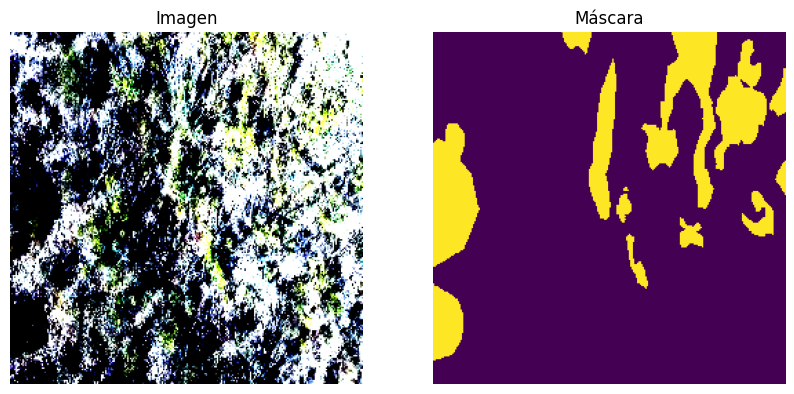

In [91]:
image, mask = train_dataset[0]

print(f"Shape de la imagen: {image.shape}")
print(f"Shape de la máscara: {mask.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # Convertir a formato (H, W, C)
plt.title("Imagen")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Máscara")
plt.axis("off")

plt.show()

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes  # Usamos el número de clases desde `_classes.csv`
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [93]:
loss_fn = FocalLoss(mode="multiclass", alpha=0.5, gamma=2.0)  # Para segmentación multiclase
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [94]:
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Salida: (batch, num_classes, H, W)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Época {epoch+1}/{num_epochs}, Pérdida: {train_loss/len(train_loader):.4f}")

Época 1/60, Pérdida: 0.2625
Época 2/60, Pérdida: 0.1793
Época 3/60, Pérdida: 0.1671
Época 4/60, Pérdida: 0.1636
Época 5/60, Pérdida: 0.1650
Época 6/60, Pérdida: 0.1583
Época 7/60, Pérdida: 0.1608
Época 8/60, Pérdida: 0.1462
Época 9/60, Pérdida: 0.1487
Época 10/60, Pérdida: 0.1583
Época 11/60, Pérdida: 0.1503
Época 12/60, Pérdida: 0.1525
Época 13/60, Pérdida: 0.1549
Época 14/60, Pérdida: 0.1476
Época 15/60, Pérdida: 0.1457
Época 16/60, Pérdida: 0.1380
Época 17/60, Pérdida: 0.1303
Época 18/60, Pérdida: 0.1344
Época 19/60, Pérdida: 0.1518
Época 20/60, Pérdida: 0.1362
Época 21/60, Pérdida: 0.1327
Época 22/60, Pérdida: 0.1321
Época 23/60, Pérdida: 0.1468
Época 24/60, Pérdida: 0.1388
Época 25/60, Pérdida: 0.1385
Época 26/60, Pérdida: 0.1403
Época 27/60, Pérdida: 0.1310
Época 28/60, Pérdida: 0.1309
Época 29/60, Pérdida: 0.1157
Época 30/60, Pérdida: 0.1303
Época 31/60, Pérdida: 0.1267
Época 32/60, Pérdida: 0.1179
Época 33/60, Pérdida: 0.1267
Época 34/60, Pérdida: 0.1243
Época 35/60, Pérdida: 0

In [95]:
import requests

# Reemplaza con tu token y chat ID
TOKEN = "7582937970:AAEjX_QwxmfjTaFEtJB8ooS4DJ9r782xts8"
CHAT_ID = "7127859860"
MENSAJE = "TERMINO DE ENTRENAR"

# URL de la API de Telegram
URL = f"https://api.telegram.org/bot{TOKEN}/sendMessage"

# Parámetros del mensaje
data = {
    "chat_id": CHAT_ID,
    "text": MENSAJE
}

# Enviar el mensaje
respuesta = requests.post(URL, json=data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


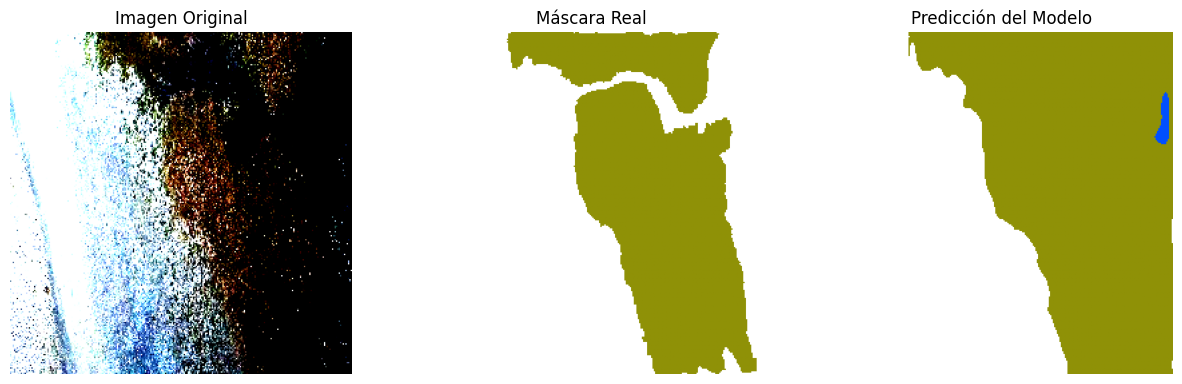

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


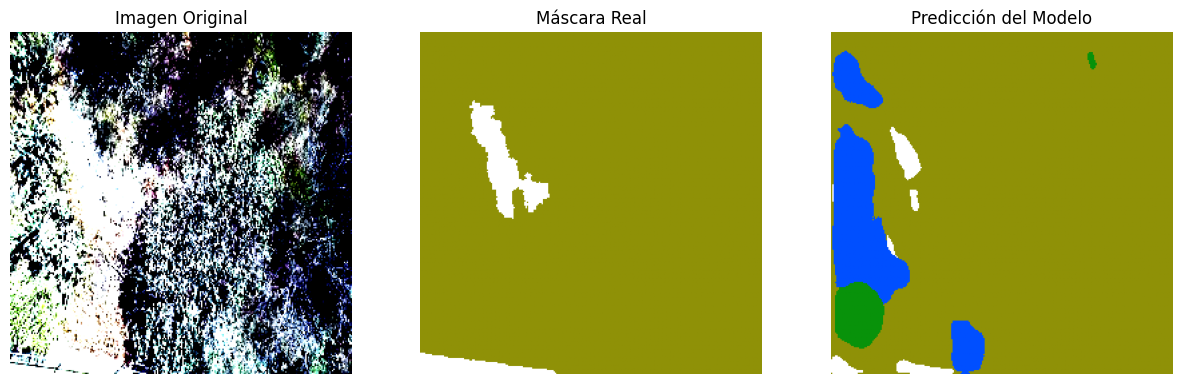

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


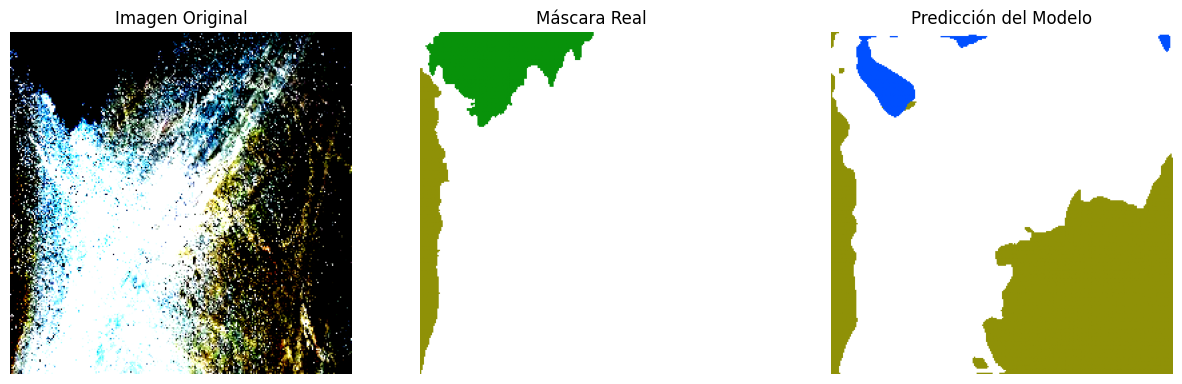

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


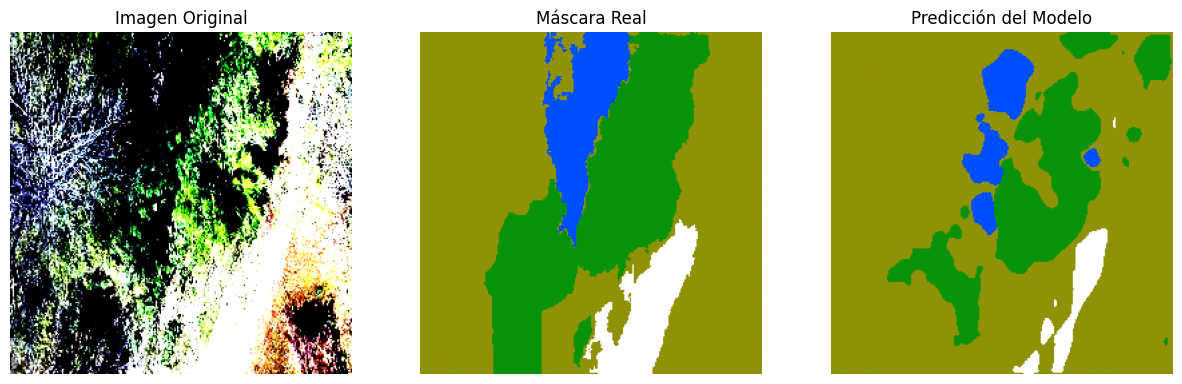

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


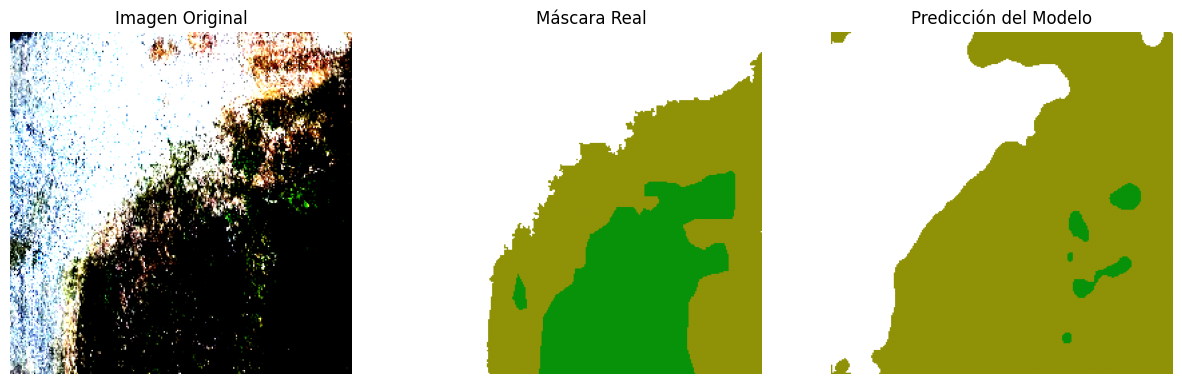

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


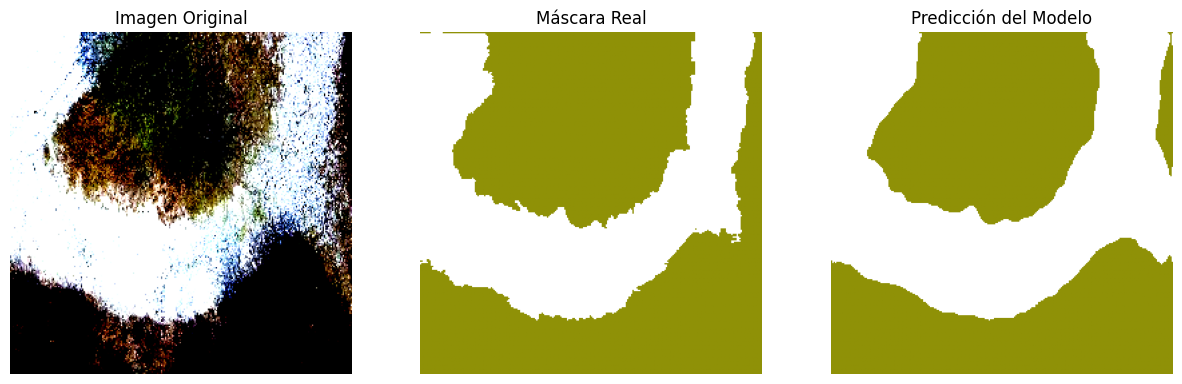

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


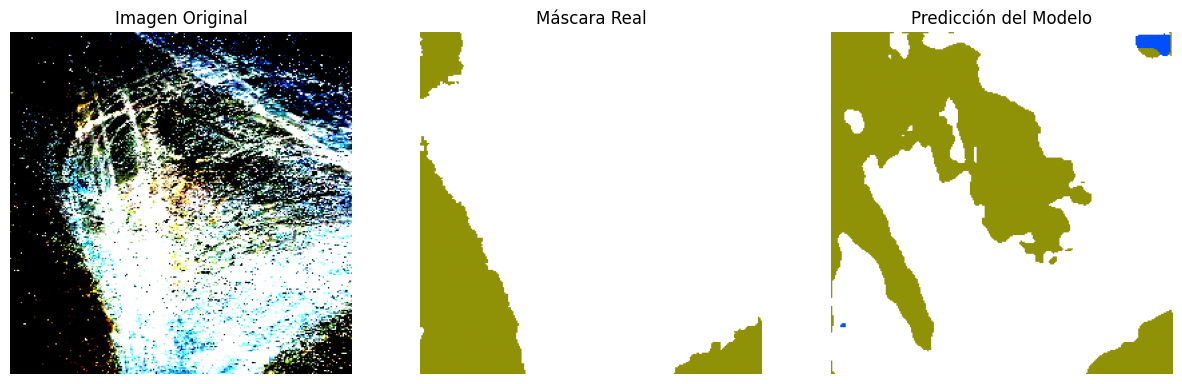

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


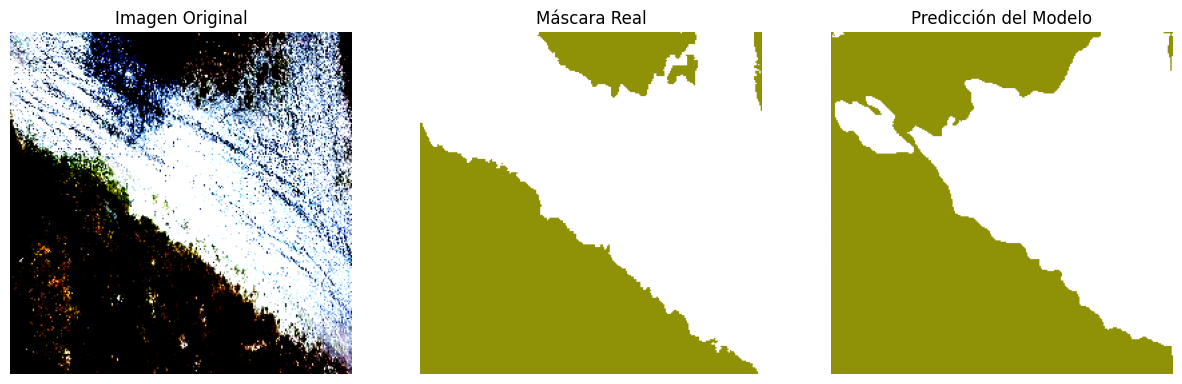

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


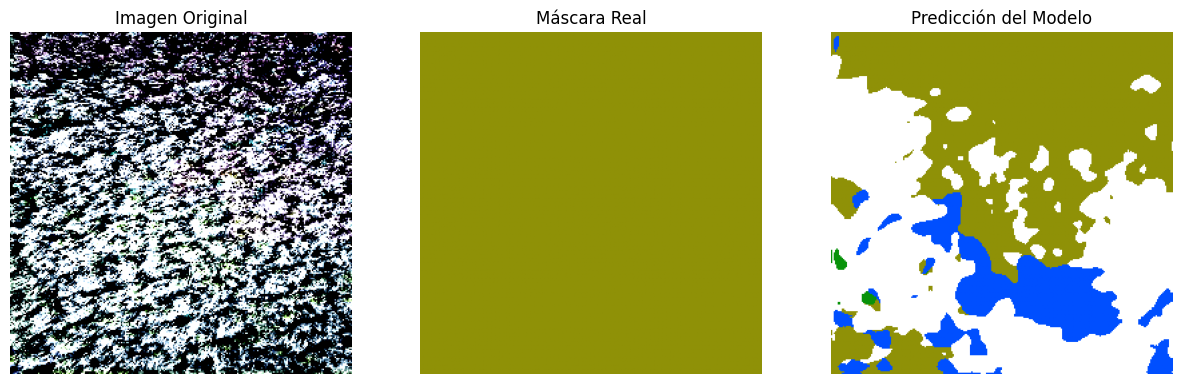

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877123].


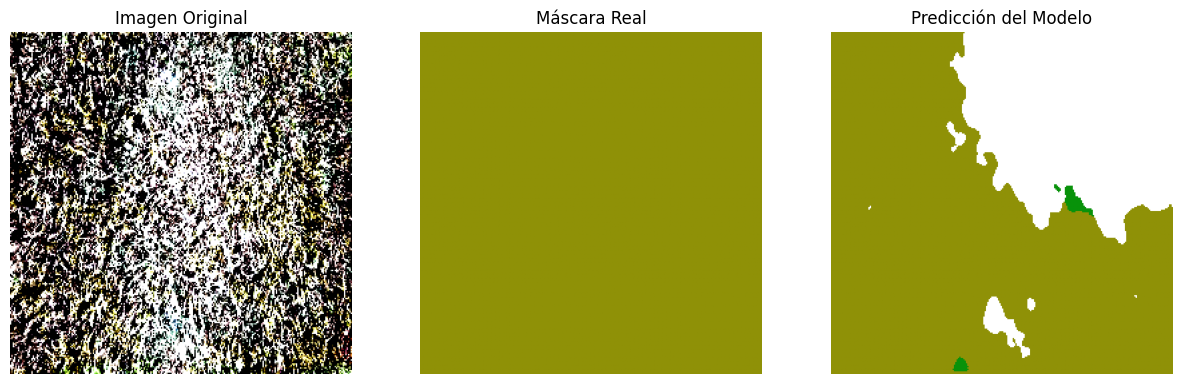

In [96]:
from matplotlib.colors import ListedColormap

# Definir colores personalizados para cada clase
custom_colors = [
    "#000000",  # 0 - Background (Negro)
    "#004fff",  # 1 - Agua (Azul)
    "#FFFFFF",  # 2 - Suelo Expuesto (Marrón)
    "#8f9107",  # 3 - Vegetación Seca (Naranja)
    "#08920a",  # 4 - Vegetación Verde (Verde)
]

# Crear un colormap personalizado
custom_cmap = ListedColormap(custom_colors)

# Definir el número máximo de imágenes a mostrar
num_images_to_show = 10  # Ajusta el número de imágenes que quieres ver

total_count = 0  # Contador global de imágenes mostradas

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Seleccionar la clase más probable

        batch_size = images.shape[0]
        
        for i in range(batch_size):
            if total_count >= num_images_to_show:
                break  # Detener si se ha alcanzado el límite de imágenes

            # Convertir a NumPy para graficar
            image_np = images[i].cpu().permute(1, 2, 0).numpy()
            mask_np = masks[i].cpu().numpy()
            pred_np = preds[i].cpu().numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(image_np)
            plt.title("Imagen Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Máscara Real")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Predicción del Modelo")
            plt.axis("off")

            plt.show()
            total_count += 1  # Incrementar el contador global

        if total_count >= num_images_to_show:
            break  # Detener el loop si se ha alcanzado el límite

In [97]:
def compute_dice(preds, masks, num_classes=5):
    preds = torch.argmax(preds, dim=1)  # Convertir logits a clases
    dice_per_class = []

    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().float()
        dice = (2. * intersection + 1e-6) / ((preds == cls).sum().float() + (masks == cls).sum().float() + 1e-6)
        dice_per_class.append(dice.item())

    return sum(dice_per_class) / num_classes  # Promedio del F1 Score (Dice)

In [98]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Calcular F1 Score (Dice)
        dice_scores.append(compute_dice(outputs, masks, num_classes=5))

# Promediar los valores obtenidos
final_dice_score = sum(dice_scores) / len(dice_scores)
print(f"\nF1 Score (Dice Score): {final_dice_score:.4f}")


F1 Score (Dice Score): 0.8257


In [99]:
def generate_confusion_report(model, test_loader, num_classes=5, class_labels=None, device="cuda"):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convertir logits a clases

            all_preds.extend(preds.cpu().numpy().flatten())
            all_masks.extend(masks.cpu().numpy().flatten())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Generar reporte de clasificación
    report = classification_report(all_masks, all_preds, target_names=class_labels, digits=4)

    return cm, report

In [100]:
class_labels = ["Agua", "Suelo Expuesto", "Vegetación Seca", "Vegetación Verde"]

In [101]:
# Generar reporte de matriz de confusión y clasificación
cm, report = generate_confusion_report(model, test_loader, num_classes=4, class_labels=class_labels, device=device)

In [102]:
print("\nReporte de Clasificación:")
print(report)


Reporte de Clasificación:
                  precision    recall  f1-score   support

            Agua     0.1498    0.2455    0.1861      5035
  Suelo Expuesto     0.7820    0.9590    0.8615    253002
 Vegetación Seca     0.9065    0.7910    0.8448    361593
Vegetación Verde     0.6310    0.3770    0.4720     35730

        accuracy                         0.8291    655360
       macro avg     0.6173    0.5931    0.5911    655360
    weighted avg     0.8376    0.8291    0.8259    655360



In [103]:
# Guardar todo el modelo
# torch.save(model, "clasificacion_suelos_2.pth")